## Feature Attention Experiments

In [ ]:
import json
import os
from typing import Dict, List, Optional, Tuple

# isort: off
from config import Config, CoreConfig, DatasetConfig, OutputConfig
from datatypes import DatasetSource, Feature, Gender
from runner import ExperimentRunner

masking_scenarios: List[Tuple[Optional[Gender], Optional[List[Feature]]]] = [
    (None, None),
    (Gender.MALE, [Feature.NOSE]),
    (Gender.FEMALE, [Feature.NOSE]),
    (Gender.MALE, [Feature.LEFT_EYE, Feature.RIGHT_EYE]),
    (Gender.FEMALE, [Feature.LEFT_EYE, Feature.RIGHT_EYE]),
]

num_replicates: int = 1
base_seed: int = 42
output_base_dir = "outputs"
cumulative_results_file = os.path.join(output_base_dir, "cumulative_masking_results.json")

results_by_masking = {}
if os.path.exists(cumulative_results_file):
    with open(cumulative_results_file, "r") as f:
        results_by_masking = json.load(f)


for scenario_index, (mask_gender, mask_features) in enumerate(masking_scenarios):

    mask_desc = f"MaskGender_{mask_gender.name if mask_gender else 'None'}_Features_{'_'.join(f.name for f in mask_features) if mask_features else 'None'}"

    if mask_desc not in results_by_masking:
        results_by_masking[mask_desc] = []

    current_run_ids_for_scenario = []

    for replicate_index in range(num_replicates):

        current_seed = base_seed + scenario_index * num_replicates + replicate_index

        core_config = CoreConfig(
            target_male_proportion=0.5,
            mask_gender=mask_gender,
            mask_features=mask_features,
            key_feature_threshold=0.3,
            random_seed=current_seed,
        )

        dataset_config = DatasetConfig(
            source_name=DatasetSource.UTKFACE,
            target_size=2000,
            image_size=48,
            use_grayscale=False,
        )

        output_config = OutputConfig(base_path=output_base_dir)

        config = Config(core=core_config, dataset=dataset_config, output=output_config)

        experiment_id = config.experiment_id
        result_file_path = os.path.join(config.output.base_path, f"{experiment_id}.json")

        if experiment_id in results_by_masking.get(mask_desc, []) or os.path.exists(result_file_path):
            current_run_ids_for_scenario.append(experiment_id)
            continue

        os.makedirs(config.output.base_path, exist_ok=True)

        runner = ExperimentRunner(config)
        experiment_result = runner.run_experiment()
        current_run_ids_for_scenario.append(experiment_result.id)

    results_by_masking[mask_desc] = sorted(list(set(results_by_masking.get(mask_desc, []) + current_run_ids_for_scenario)))

    with open(cumulative_results_file, "w") as f:
        json.dump(results_by_masking, f, indent=4)

In [ ]:

masking_scenarios: List[Tuple[Optional[Gender], Optional[List[Feature]]]] = [
    (None, None),
    (Gender.MALE, [Feature.NOSE]),
    (Gender.FEMALE, [Feature.NOSE]),
    (Gender.MALE, [Feature.LEFT_EYE, Feature.RIGHT_EYE]),
    (Gender.FEMALE, [Feature.LEFT_EYE, Feature.RIGHT_EYE]),
]

num_replicates: int = 1
base_seed: int = 42
results_by_masking: Dict[str, List[str]] = {}

print(f"Starting feature masking experiments on gender-balanced data (50% Male) with {num_replicates} replicates...")

for scenario_index, (mask_gender, mask_features) in enumerate(masking_scenarios):

    mask_desc = f"MaskGender_{mask_gender.name if mask_gender else 'None'}_Features_{'_'.join(f.name for f in mask_features) if mask_features else 'None'}"
    print(f"\nProcessing Scenario: {mask_desc}")
    results_by_masking[mask_desc] = []

    for replicate_index in range(num_replicates):

        current_seed = base_seed + scenario_index * num_replicates + replicate_index

        core_config = CoreConfig(
            target_male_proportion=0.5,
            mask_gender=mask_gender,
            mask_features=mask_features,
            key_feature_threshold=0.3,
            random_seed=current_seed,
        )

        dataset_config = DatasetConfig(
            source_name=DatasetSource.UTKFACE,
            target_size=2000,
            image_size=48,
            use_grayscale=False,
        )

        config = Config(core=core_config, dataset=dataset_config)

        print(f"  Running Replicate {replicate_index+1}/{num_replicates} (Seed: {current_seed}, Config ID: {config.experiment_id})")

        try:
            runner = ExperimentRunner(config)
            experiment_result = runner.run_experiment()
            results_by_masking[mask_desc].append(experiment_result.id)
            print(f"    Completed Replicate - Experiment ID: {experiment_result.id}")
        except Exception as e:
            print(f"    !!! Replicate Failed: {e}")
            results_by_masking[mask_desc].append(f"FAILED_Seed_{current_seed}")


print("\n--- Experiment Summary ---")
for desc, exp_ids in results_by_masking.items():
    print(f"{desc}:")
    for i, exp_id in enumerate(exp_ids):
        print(f"  Replicate {i+1}: {exp_id}")

print("\nExperiment runs complete.")

In [5]:
masking_results_map = {
    "MaskGender_None_Features_None": ["6c021674ed1d287f"],
    "MaskGender_MALE_Features_NOSE": ["93615b7cd03947c1"],
    "MaskGender_FEMALE_Features_NOSE": ["50833a93dbc772f0"],
    "MaskGender_MALE_Features_LEFT_EYE_RIGHT_EYE": ["bceb43eea8e0912b"],
    "MaskGender_FEMALE_Features_LEFT_EYE_RIGHT_EYE": ["43a02afff9f7d671"],
}
output_dir = "outputs"

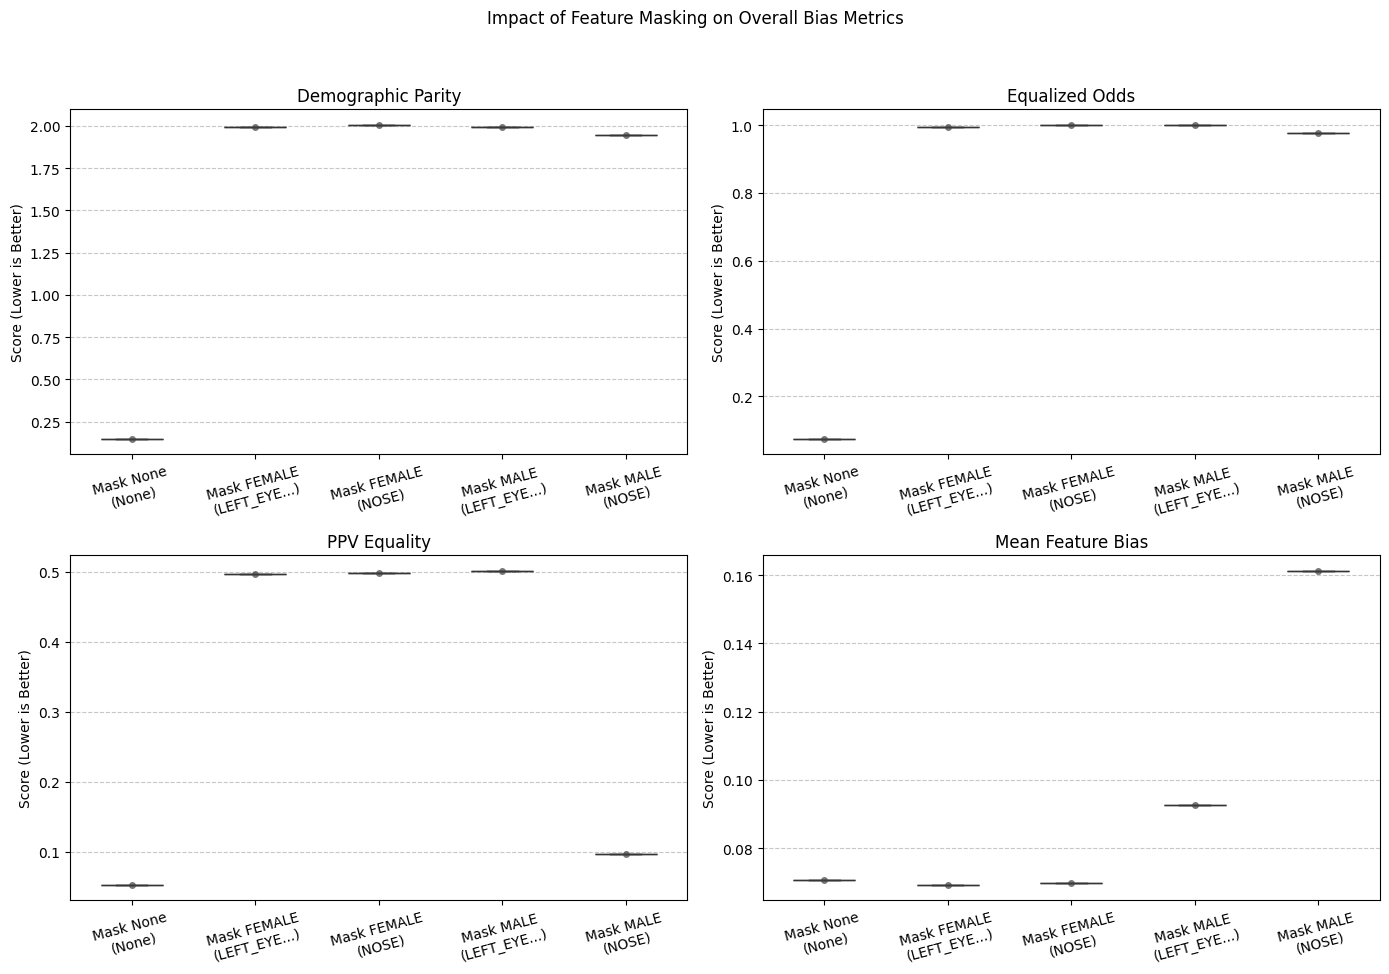

In [6]:
import json
import os
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_masking_bias_impact(results_by_masking: Dict[str, List[str]], base_path: str) -> None:
    """Plots the impact of different masking scenarios on overall bias metrics using subplots."""
    plot_data = []

    metric_display_names = {"demographic_parity": "Demographic Parity", "equalized_odds": "Equalized Odds", "conditional_use_accuracy_equality": "PPV Equality", "mean_feature_distribution_bias": "Mean Feature Bias"}

    # Shorten scenario names for plotting if needed
    scenario_display_map = {}
    for scenario_key in results_by_masking.keys():
        # Example shortening logic - adjust as needed
        parts = scenario_key.split("_Features_")
        mask_gender_part = parts[0].replace("MaskGender_", "")
        mask_features_part = parts[1] if len(parts) > 1 else "None"
        if mask_features_part != "None":
            # Limit feature list length description if too long
            features = mask_features_part.split("_")
            if len(features) > 2:
                mask_features_part = f"{features[0]}_{features[1]}..."
            else:
                mask_features_part = mask_features_part.replace("_", "+")

        scenario_display_map[scenario_key] = f"Mask {mask_gender_part}\n({mask_features_part})"

    for scenario_key, experiment_ids in results_by_masking.items():
        scenario_display_name = scenario_display_map.get(scenario_key, scenario_key)  # Use shortened name
        for exp_id in experiment_ids:
            # Skip failed replicates
            if isinstance(exp_id, str) and exp_id.startswith("FAILED"):
                print(f"Skipping failed replicate for scenario {scenario_key}: {exp_id}")
                continue

            file_path = os.path.join(base_path, f"{exp_id}.json")
            try:
                with open(file_path, "r") as f:
                    result_dict = json.load(f)

                analysis = result_dict.get("analysis")
                bias_metrics = analysis.get("bias_metrics") if analysis else None

                if bias_metrics:
                    for metric_key, metric_value in bias_metrics.items():
                        if metric_key in metric_display_names:
                            plot_data.append({"Masking Scenario": scenario_display_name, "Metric Value": metric_value, "Bias Metric": metric_display_names[metric_key], "Experiment ID": exp_id})
                else:
                    print(f"Warning: Bias metrics not found for Experiment ID {exp_id}")

            except FileNotFoundError:
                print(f"Warning: Result file not found for Experiment ID {exp_id} at {file_path}")
            except json.JSONDecodeError:
                print(f"Warning: Could not decode JSON for Experiment ID {exp_id}")
            except Exception as e:
                print(f"Warning: An error occurred processing Experiment ID {exp_id}: {e}")

    if not plot_data:
        print("No data available for plotting masking impact on bias metrics.")
        return

    metrics_df = pd.DataFrame(plot_data)

    metric_list = list(metric_display_names.values())
    num_metrics = len(metric_list)

    # Determine grid size (prefer 2 columns)
    ncols = 2
    nrows = (num_metrics + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 5 * nrows))  # Consistent width, height based on rows
    axes = axes.flatten()  # Flatten for easy iteration

    # Define order for scenarios if needed, e.g., put 'None' first
    scenario_order = sorted(list(set(metrics_df["Masking Scenario"])), key=lambda x: ("None" not in x, x))

    for i, metric_name in enumerate(metric_list):
        ax = axes[i]
        metric_subset_df = metrics_df[metrics_df["Bias Metric"] == metric_name]

        if metric_subset_df.empty:
            ax.set_title(f"{metric_name}\n(No Data)")
            ax.set_yticks([])
            continue

        # Combine boxplot and stripplot
        sns.boxplot(data=metric_subset_df, x="Masking Scenario", y="Metric Value", order=scenario_order, ax=ax, palette="viridis", showfliers=False, width=0.5)
        sns.stripplot(data=metric_subset_df, x="Masking Scenario", y="Metric Value", order=scenario_order, ax=ax, color=".25", size=5, alpha=0.7)

        ax.set_title(f"{metric_name}")
        ax.set_ylabel("Score (Lower is Better)")
        ax.set_xlabel(None)  # Shared x-label or remove if clear from title
        ax.tick_params(axis="x", rotation=15)  # Slight rotation for potentially long labels
        ax.grid(axis="y", linestyle="--", alpha=0.7)

    # Hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Impact of Feature Masking on Overall Bias Metrics", y=1.0)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout
    plt.show()


plot_masking_bias_impact(masking_results_map, output_dir)

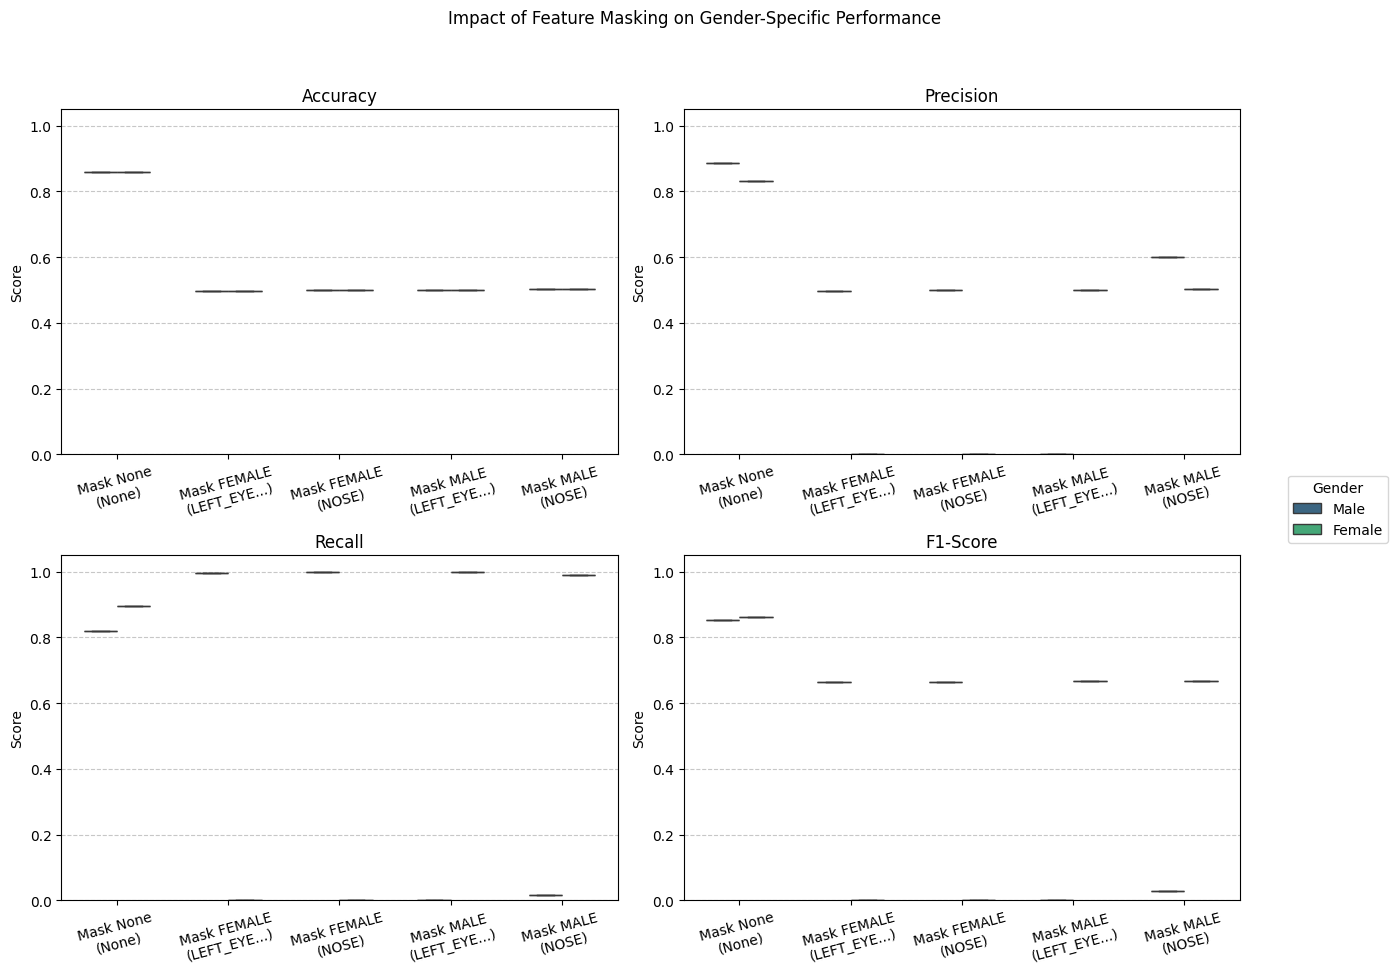

In [7]:
import json
import os
from typing import Any, Dict, List, Optional

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Re-defining helper function here to make the code block self-contained
def _calculate_perf_metrics(metrics: Optional[Dict[str, Any]]) -> Optional[Dict[str, float]]:
    """Helper to calculate Accuracy, Precision, Recall, F1 from TP/FP/TN/FN."""
    if not metrics:
        return None

    tp = metrics.get("tp", 0)
    fp = metrics.get("fp", 0)
    tn = metrics.get("tn", 0)
    fn = metrics.get("fn", 0)
    total = tp + fp + tn + fn

    accuracy = (tp + tn) / total if total > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0  # PPV
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # TPR
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}


def plot_masking_performance_impact(results_by_masking: Dict[str, List[str]], base_path: str) -> None:
    """Plots the impact of masking scenarios on gender-specific performance metrics."""
    plot_data = []
    gender_keys = {"Male": "male_performance_metrics", "Female": "female_performance_metrics"}

    # Shorten scenario names for plotting if needed (same logic as previous function)
    scenario_display_map = {}
    for scenario_key in results_by_masking.keys():
        parts = scenario_key.split("_Features_")
        mask_gender_part = parts[0].replace("MaskGender_", "")
        mask_features_part = parts[1] if len(parts) > 1 else "None"
        if mask_features_part != "None":
            features = mask_features_part.split("_")
            if len(features) > 2:
                mask_features_part = f"{features[0]}_{features[1]}..."
            else:
                mask_features_part = mask_features_part.replace("_", "+")
        scenario_display_map[scenario_key] = f"Mask {mask_gender_part}\n({mask_features_part})"

    for scenario_key, experiment_ids in results_by_masking.items():
        scenario_display_name = scenario_display_map.get(scenario_key, scenario_key)  # Use shortened name
        for exp_id in experiment_ids:
            # Skip failed replicates
            if isinstance(exp_id, str) and exp_id.startswith("FAILED"):
                print(f"Skipping failed replicate for scenario {scenario_key}: {exp_id}")
                continue

            file_path = os.path.join(base_path, f"{exp_id}.json")
            try:
                with open(file_path, "r") as f:
                    result_dict = json.load(f)

                analysis = result_dict.get("analysis")
                if not analysis:
                    print(f"Warning: Analysis data not found for Experiment ID {exp_id}")
                    continue

                for gender_name, metrics_key in gender_keys.items():
                    perf_metrics_raw = analysis.get(metrics_key)
                    perf_metrics_calc = _calculate_perf_metrics(perf_metrics_raw)

                    if perf_metrics_calc:
                        for metric_name, metric_value in perf_metrics_calc.items():
                            plot_data.append({"Masking Scenario": scenario_display_name, "Metric Value": metric_value, "Performance Metric": metric_name, "Gender": gender_name, "Experiment ID": exp_id})
                    else:
                        print(f"Warning: Could not calculate performance metrics for {gender_name} in Exp ID {exp_id}")

            except FileNotFoundError:
                print(f"Warning: Result file not found for Experiment ID {exp_id} at {file_path}")
            except json.JSONDecodeError:
                print(f"Warning: Could not decode JSON for Experiment ID {exp_id}")
            except Exception as e:
                print(f"Warning: An error occurred processing Experiment ID {exp_id}: {e}")

    if not plot_data:
        print("No data available for plotting masking impact on performance metrics.")
        return

    metrics_df = pd.DataFrame(plot_data)

    metric_list = ["Accuracy", "Precision", "Recall", "F1-Score"]
    num_metrics = len(metric_list)

    # Determine grid size (prefer 2 columns)
    ncols = 2
    nrows = (num_metrics + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 5 * nrows))  # Consistent width
    axes = axes.flatten()  # Flatten for easy iteration

    # Define order for scenarios if needed
    scenario_order = sorted(list(set(metrics_df["Masking Scenario"])), key=lambda x: ("None" not in x, x))

    for i, metric_name in enumerate(metric_list):
        ax = axes[i]
        metric_subset_df = metrics_df[metrics_df["Performance Metric"] == metric_name]

        if metric_subset_df.empty:
            ax.set_title(f"{metric_name}\n(No Data)")
            ax.set_yticks([])
            continue

        # Combine boxplot and stripplot
        sns.boxplot(data=metric_subset_df, x="Masking Scenario", y="Metric Value", hue="Gender", order=scenario_order, ax=ax, palette="viridis", showfliers=False, width=0.6)
        # Use dodge=True in stripplot if you want points separated by hue like the boxes
        # sns.stripplot(data=metric_subset_df, x="Masking Scenario", y="Metric Value", hue="Gender",
        #               order=scenario_order, ax=ax, color=".25", size=4, alpha=0.6, dodge=True)

        ax.set_title(f"{metric_name}")
        ax.set_ylabel("Score")
        ax.set_xlabel(None)
        ax.set_ylim(0, 1.05)
        ax.tick_params(axis="x", rotation=15)
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        # Remove individual legends from subplots if combining later
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    # Hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add a single combined legend
    handles, labels = axes[0].get_legend_handles_labels()  # Get handles/labels from the first plot
    fig.legend(handles, labels, title="Gender", loc="center right", bbox_to_anchor=(1.0, 0.5))

    fig.suptitle("Impact of Feature Masking on Gender-Specific Performance", y=1.0)
    plt.tight_layout(rect=[0, 0.03, 0.9, 0.97])  # Adjust layout
    plt.show()


plot_masking_performance_impact(masking_results_map, output_dir)

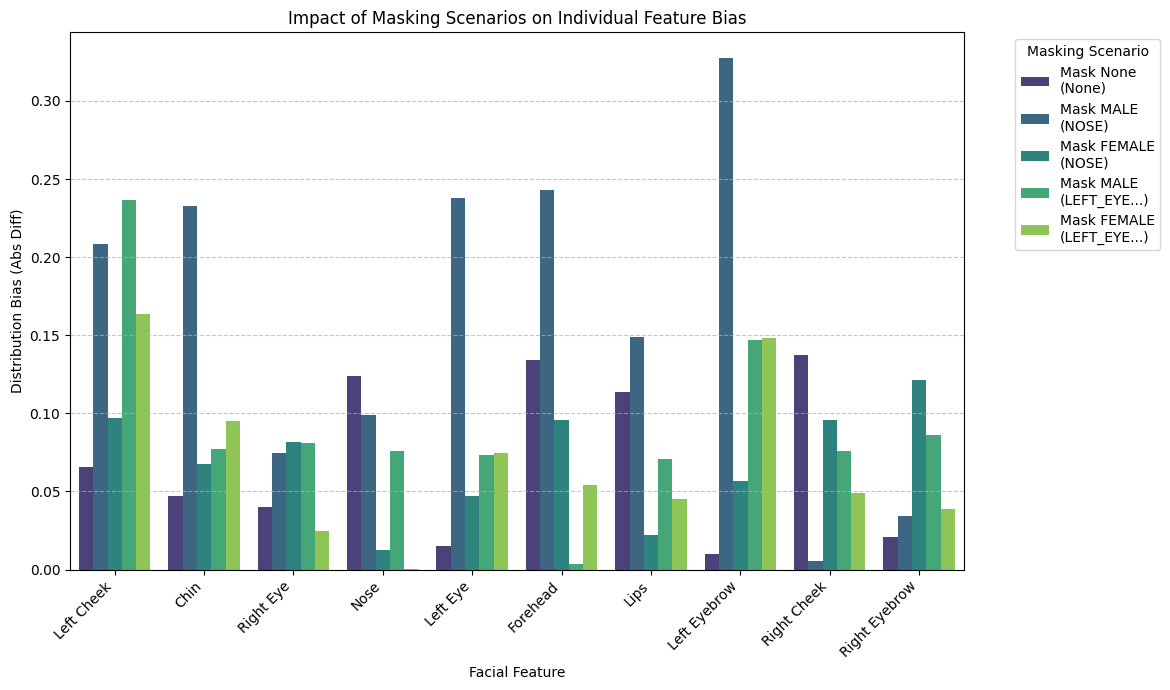

In [8]:
import json
import os
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_masking_feature_bias(results_by_masking: Dict[str, List[str]], base_path: str) -> None:
    """Plots the impact of masking scenarios on the distribution bias of individual features."""
    plot_data = []

    # Shorten scenario names for plotting if needed (same logic as previous function)
    scenario_display_map = {}
    for scenario_key in results_by_masking.keys():
        parts = scenario_key.split("_Features_")
        mask_gender_part = parts[0].replace("MaskGender_", "")
        mask_features_part = parts[1] if len(parts) > 1 else "None"
        if mask_features_part != "None":
            features = mask_features_part.split("_")
            if len(features) > 2:
                mask_features_part = f"{features[0]}_{features[1]}..."
            else:
                mask_features_part = mask_features_part.replace("_", "+")
        scenario_display_map[scenario_key] = f"Mask {mask_gender_part}\n({mask_features_part})"

    for scenario_key, experiment_ids in results_by_masking.items():
        scenario_display_name = scenario_display_map.get(scenario_key, scenario_key)  # Use shortened name
        for exp_id in experiment_ids:
            # Skip failed replicates
            if isinstance(exp_id, str) and exp_id.startswith("FAILED"):
                print(f"Skipping failed replicate for scenario {scenario_key}: {exp_id}")
                continue

            file_path = os.path.join(base_path, f"{exp_id}.json")
            try:
                with open(file_path, "r") as f:
                    result_dict = json.load(f)

                analysis = result_dict.get("analysis")
                if not analysis:
                    print(f"Warning: Analysis data not found for Experiment ID {exp_id}")
                    continue

                feature_distributions = analysis.get("feature_distributions")
                if not feature_distributions:
                    print(f"Warning: Feature distributions not found for Experiment ID {exp_id}")
                    continue

                for dist_data in feature_distributions:
                    feature_name = dist_data.get("feature")
                    distribution_bias = dist_data.get("distribution_bias")

                    if feature_name and distribution_bias is not None:
                        # Clean up feature name for display
                        display_feature_name = feature_name.replace("_", " ").title()
                        plot_data.append({"Masking Scenario": scenario_display_name, "Distribution Bias": distribution_bias, "Feature": display_feature_name, "Experiment ID": exp_id})
                    else:
                        print(f"Warning: Missing feature name or bias value in distribution data for Exp ID {exp_id}")

            except FileNotFoundError:
                print(f"Warning: Result file not found for Experiment ID {exp_id} at {file_path}")
            except json.JSONDecodeError:
                print(f"Warning: Could not decode JSON for Experiment ID {exp_id}")
            except Exception as e:
                print(f"Warning: An error occurred processing Experiment ID {exp_id}: {e}")

    if not plot_data:
        print("No data available for plotting masking impact on feature bias.")
        return

    feature_bias_df = pd.DataFrame(plot_data)

    plt.figure(figsize=(14, 7))  # Consistent width

    # Use barplot - aggregates replicates using mean by default
    ax = sns.barplot(data=feature_bias_df, x="Feature", y="Distribution Bias", hue="Masking Scenario", palette="viridis", errorbar=("ci", 95))  # Show 95% CI bars for replicate variance

    plt.title("Impact of Masking Scenarios on Individual Feature Bias")
    plt.xlabel("Facial Feature")
    plt.ylabel("Distribution Bias (Abs Diff)")
    plt.ylim(bottom=0)
    plt.xticks(rotation=45, ha="right")  # Rotate labels for better visibility
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.legend(title="Masking Scenario", bbox_to_anchor=(1.05, 1), loc="upper left")  # Place legend outside plot

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for legend
    plt.show()


plot_masking_feature_bias(masking_results_map, output_dir)

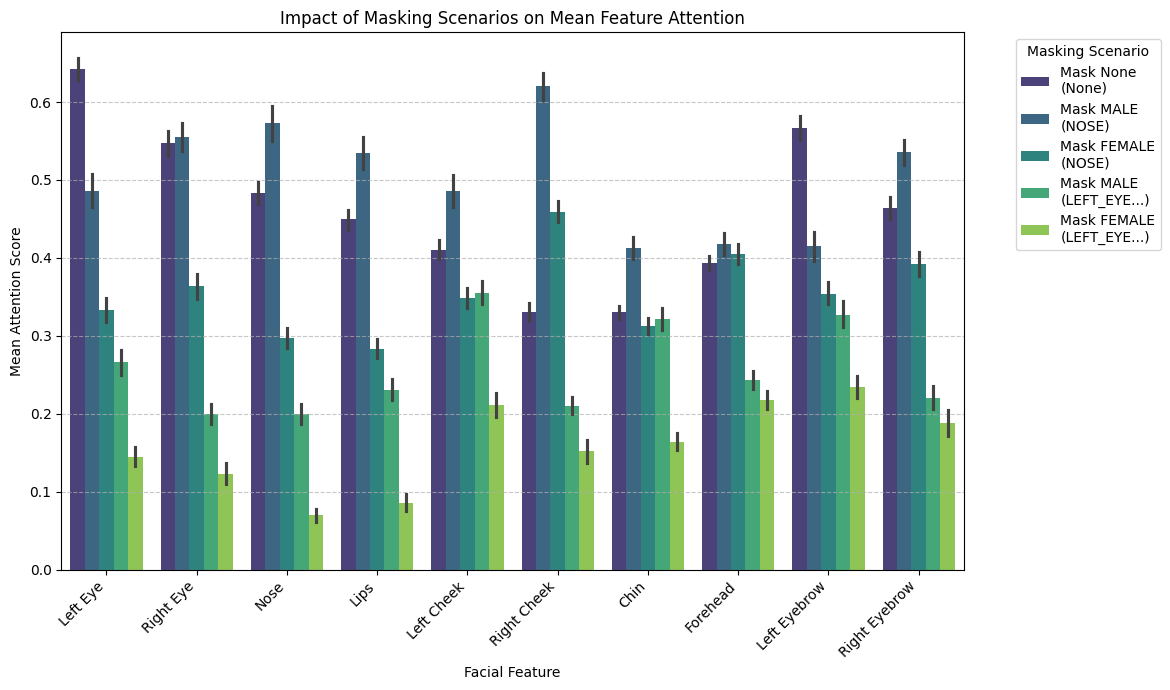

In [9]:
import json
import os
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_masking_attention_impact(results_by_masking: Dict[str, List[str]], base_path: str) -> None:
    """Plots the impact of masking scenarios on mean feature attention scores."""
    plot_data = []

    # Shorten scenario names for plotting if needed (same logic as previous function)
    scenario_display_map = {}
    for scenario_key in results_by_masking.keys():
        parts = scenario_key.split("_Features_")
        mask_gender_part = parts[0].replace("MaskGender_", "")
        mask_features_part = parts[1] if len(parts) > 1 else "None"
        if mask_features_part != "None":
            features = mask_features_part.split("_")
            if len(features) > 2:
                mask_features_part = f"{features[0]}_{features[1]}..."
            else:
                mask_features_part = mask_features_part.replace("_", "+")
        scenario_display_map[scenario_key] = f"Mask {mask_gender_part}\n({mask_features_part})"

    for scenario_key, experiment_ids in results_by_masking.items():
        scenario_display_name = scenario_display_map.get(scenario_key, scenario_key)  # Use shortened name
        for exp_id in experiment_ids:
            # Skip failed replicates
            if isinstance(exp_id, str) and exp_id.startswith("FAILED"):
                print(f"Skipping failed replicate for scenario {scenario_key}: {exp_id}")
                continue

            file_path = os.path.join(base_path, f"{exp_id}.json")
            try:
                with open(file_path, "r") as f:
                    result_dict = json.load(f)

                analysis = result_dict.get("analysis")
                if not analysis:
                    print(f"Warning: Analysis data not found for Experiment ID {exp_id}")
                    continue

                analyzed_images = analysis.get("analyzed_images")
                if not analyzed_images:
                    print(f"Warning: Analyzed images not found for Experiment ID {exp_id}")
                    continue

                for img_data in analyzed_images:
                    detected_features = img_data.get("detected_features", [])
                    for feature_detail in detected_features:
                        feature_name = feature_detail.get("feature")
                        attention_score = feature_detail.get("attention_score")

                        if feature_name and attention_score is not None:
                            # Clean up feature name for display
                            display_feature_name = feature_name.replace("_", " ").title()
                            plot_data.append({"Masking Scenario": scenario_display_name, "Attention Score": attention_score, "Feature": display_feature_name, "Experiment ID": exp_id})  # Store individual scores
                        # No else needed, just skip if data missing for a feature

            except FileNotFoundError:
                print(f"Warning: Result file not found for Experiment ID {exp_id} at {file_path}")
            except json.JSONDecodeError:
                print(f"Warning: Could not decode JSON for Experiment ID {exp_id}")
            except Exception as e:
                print(f"Warning: An error occurred processing Experiment ID {exp_id}: {e}")

    if not plot_data:
        print("No data available for plotting masking impact on feature attention.")
        return

    attention_df = pd.DataFrame(plot_data)

    plt.figure(figsize=(14, 7))  # Consistent width

    # Use barplot - calculates mean of 'Attention Score' by default
    ax = sns.barplot(data=attention_df, x="Feature", y="Attention Score", hue="Masking Scenario", palette="viridis", errorbar=("ci", 95))  # Show 95% CI bars

    plt.title("Impact of Masking Scenarios on Mean Feature Attention")
    plt.xlabel("Facial Feature")
    plt.ylabel("Mean Attention Score")
    plt.ylim(bottom=0)  # Attention score likely non-negative
    plt.xticks(rotation=45, ha="right")  # Rotate labels for better visibility
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.legend(title="Masking Scenario", bbox_to_anchor=(1.05, 1), loc="upper left")  # Place legend outside plot

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for legend
    plt.show()


plot_masking_attention_impact(masking_results_map, output_dir)

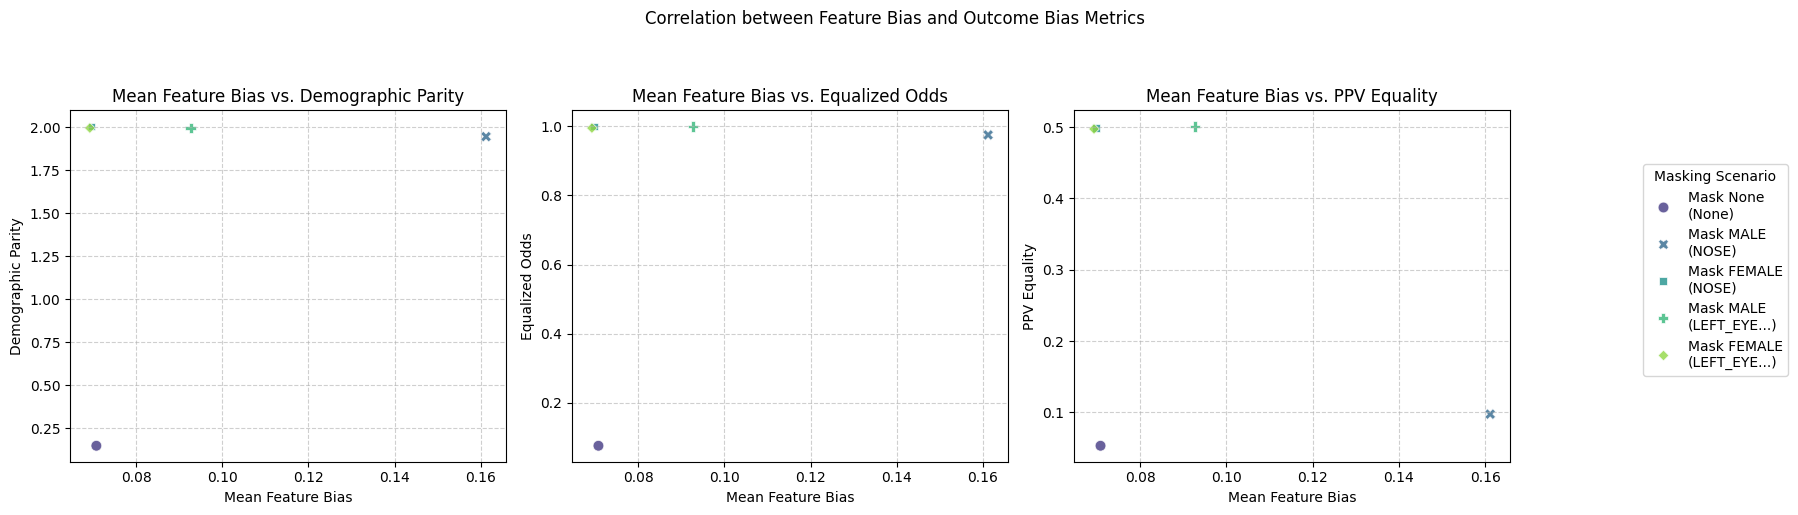

In [10]:
import json
import os
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_masking_bias_correlation(results_by_masking: Dict[str, List[str]], base_path: str) -> None:
    """Plots correlations between feature bias and outcome bias metrics across masking scenarios."""
    plot_data = []

    metric_keys_to_extract = ["mean_feature_distribution_bias", "demographic_parity", "equalized_odds", "conditional_use_accuracy_equality"]

    metric_display_names = {"mean_feature_distribution_bias": "Mean Feature Bias", "demographic_parity": "Demographic Parity", "equalized_odds": "Equalized Odds", "conditional_use_accuracy_equality": "PPV Equality"}

    # Shorten scenario names for plotting (same logic as previous functions)
    scenario_display_map = {}
    for scenario_key in results_by_masking.keys():
        parts = scenario_key.split("_Features_")
        mask_gender_part = parts[0].replace("MaskGender_", "")
        mask_features_part = parts[1] if len(parts) > 1 else "None"
        if mask_features_part != "None":
            features = mask_features_part.split("_")
            if len(features) > 2:
                mask_features_part = f"{features[0]}_{features[1]}..."
            else:
                mask_features_part = mask_features_part.replace("_", "+")
        scenario_display_map[scenario_key] = f"Mask {mask_gender_part}\n({mask_features_part})"

    for scenario_key, experiment_ids in results_by_masking.items():
        scenario_display_name = scenario_display_map.get(scenario_key, scenario_key)  # Use shortened name
        for exp_id in experiment_ids:
            # Skip failed replicates
            if isinstance(exp_id, str) and exp_id.startswith("FAILED"):
                print(f"Skipping failed replicate for scenario {scenario_key}: {exp_id}")
                continue

            file_path = os.path.join(base_path, f"{exp_id}.json")
            try:
                with open(file_path, "r") as f:
                    result_dict = json.load(f)

                analysis = result_dict.get("analysis")
                bias_metrics = analysis.get("bias_metrics") if analysis else None

                if bias_metrics:
                    record = {"Masking Scenario": scenario_display_name, "Experiment ID": exp_id}
                    valid_record = True
                    for metric_key in metric_keys_to_extract:
                        if metric_key in bias_metrics:
                            record[metric_display_names[metric_key]] = bias_metrics[metric_key]
                        else:
                            print(f"Warning: Metric '{metric_key}' not found for Exp ID {exp_id}")
                            valid_record = False
                            break
                    if valid_record:
                        plot_data.append(record)
                else:
                    print(f"Warning: Bias metrics not found for Experiment ID {exp_id}")

            except FileNotFoundError:
                print(f"Warning: Result file not found for Experiment ID {exp_id} at {file_path}")
            except json.JSONDecodeError:
                print(f"Warning: Could not decode JSON for Experiment ID {exp_id}")
            except Exception as e:
                print(f"Warning: An error occurred processing Experiment ID {exp_id}: {e}")

    if not plot_data:
        print("No data available for plotting bias metric correlations.")
        return

    if len(plot_data) < 2:
        print("Need at least two data points to plot correlations.")
        return

    metrics_df = pd.DataFrame(plot_data)

    x_metric = "Mean Feature Bias"
    y_metrics = ["Demographic Parity", "Equalized Odds", "PPV Equality"]

    ncols = len(y_metrics)
    nrows = 1

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))  # Consistent height, width based on cols
    if ncols == 1:  # Handle case where axes is not an array
        axes = [axes]

    axes = axes.flatten()

    for i, y_metric in enumerate(y_metrics):
        ax = axes[i]

        sns.scatterplot(data=metrics_df, x=x_metric, y=y_metric, hue="Masking Scenario", style="Masking Scenario", ax=ax, palette="viridis", s=60, alpha=0.8)

        # Optional: Add overall regression line
        # sns.regplot(data=metrics_df, x=x_metric, y=y_metric, ax=ax, scatter=False, color='gray')

        ax.set_title(f"{x_metric} vs. {y_metric}")
        ax.set_xlabel(x_metric)
        ax.set_ylabel(y_metric)
        ax.grid(True, linestyle="--", alpha=0.6)
        # Remove individual legends if combining later
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    # Add a single combined legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Masking Scenario", loc="center right", bbox_to_anchor=(1.0, 0.5))

    fig.suptitle("Correlation between Feature Bias and Outcome Bias Metrics", y=1.02)
    plt.tight_layout(rect=[0, 0, 0.85, 0.96])  # Adjust layout
    plt.show()


plot_masking_bias_correlation(masking_results_map, output_dir)